# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_004  Q14C87           15.279
Sample_145  Q8NBP7           14.494
Sample_056  J3KNA1;Q12840    18.491
Sample_144  F8WE04;P04792    15.168
Sample_044  Q9UP79           15.819
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups
Sample_045  P06702           15.111
Sample_044  Q14DG7           15.201
Sample_108  P16930           15.582
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.040
            A0A075B6Q5                 11.510
            A0A075B6R2                 13.398
            A0A075B6S5                 13.170
            A0A087WSY4                 13.008
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.529
            Q9UI40;Q9UI40-2            12.512
            Q9UIW2                     12.332
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.099
            Q9UP79                     12.511
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.719,15.050,16.842,19.863,16.202,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.924,19.067,...,15.528,15.576,13.590,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.061,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.121,17.705,17.039,15.280,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.695,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.492,15.345,17.084,18.708,14.249,19.433,12.120,10.901
Sample_207,15.739,16.877,15.469,16.898,12.899,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.040,...,16.012,15.178,12.091,15.050,16.842,19.863,12.053,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.465,19.067,16.188,...,15.528,15.576,12.538,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.797,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.458,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.201,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.764,15.345,17.084,18.708,14.249,19.433,12.335,13.982
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 178.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.49it/s]

100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.24it/s]

100%|██████████| 4/4 [00:01<00:00,  1.97it/s]

100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.80it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.55it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.26it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.62it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.35it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.21it/s]

100%|██████████| 6/6 [00:02<00:00,  2.03it/s]

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.26it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.59it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.54it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.22it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.05it/s]

100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.19it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.96it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.92it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.38it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.22it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.11it/s]

100%|██████████| 8/8 [00:03<00:00,  2.25it/s]

100%|██████████| 8/8 [00:03<00:00,  2.50it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.23it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.90it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.22it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.01it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.47it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.11it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.98it/s]

100%|██████████| 9/9 [00:03<00:00,  2.14it/s]

100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.46it/s]

 30%|███       | 3/10 [00:00<00:01,  3.77it/s]

 40%|████      | 4/10 [00:01<00:01,  3.38it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.20it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.01it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.48it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.22it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.03it/s]

100%|██████████| 10/10 [00:03<00:00,  2.10it/s]

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.97it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.57it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.24it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.09it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.84it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.36it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.13it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.05it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.99it/s]

100%|██████████| 11/11 [00:04<00:00,  2.18it/s]

100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.83it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.94it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.26it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.11it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.97it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.89it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.48it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.33it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.24it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.10it/s]

100%|██████████| 12/12 [00:04<00:00,  2.25it/s]

100%|██████████| 12/12 [00:04<00:00,  2.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.00it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.99it/s]

 31%|███       | 4/13 [00:01<00:02,  3.46it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.11it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.93it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.97it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.00it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.66it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.15it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.07it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  1.94it/s]

100%|██████████| 13/13 [00:05<00:00,  1.86it/s]

100%|██████████| 13/13 [00:05<00:00,  2.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.59it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.01it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.40it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.90it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.39it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.13it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.99it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  1.89it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.83it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.83it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.85it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.06it/s]

100%|██████████| 14/14 [00:06<00:00,  2.22it/s]

100%|██████████| 14/14 [00:06<00:00,  2.25it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.08it/s]

 20%|██        | 3/15 [00:00<00:03,  3.85it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.54it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.13it/s]

 40%|████      | 6/15 [00:01<00:03,  2.78it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.77it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.28it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.07it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.88it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.70it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.76it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.73it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.91it/s]

100%|██████████| 15/15 [00:06<00:00,  2.08it/s]

100%|██████████| 15/15 [00:06<00:00,  2.24it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.062 0.029          0.687 0.393       0.100   
2             0.005 0.004      0.057 0.018          0.632 0.146       0.457   
3             0.004 0.001      0.055 0.022          0.798 0.079       0.713   
4             0.004 0.003      0.054 0.019          0.804 0.078       0.767   
5             0.004 0.001      0.052 0.017          0.828 0.081       0.793   
6             0.004 0.000      0.052 0.014          0.825 0.087       0.790   
7             0.005 0.003      0.056 0.018          0.829 0.074       0.836   
8             0.004 0.002      0.052 0.012          0.828 0.077       0.830   
9             0.005 0.003      0.053 0.015          0.832 0.076       0.823   
10            0.005 0.003      0.056 0.015          0.832 0.075       0.822   
11            0.005 0.004      0.060 0.020          0.842 0.079       0.808   
12            0.005 0.003      0.057 0.019          0.840 0.078       0.806   
13            0.007 0.006      0.091 0.028          0.829 0.084       0.806   
14            0.007 0.005      0.076 0.032          0.822 0.088       0.793   
15            0.005 0.003      0.065 0.026          0.819 0.086       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.168 0.130                  0.542 0.042        0.846   
2          0.113   0.519 0.097                  0.624 0.066        0.698   
3          0.105   0.747 0.069                  0.789 0.055        0.896   
4          0.109   0.780 0.071                  0.814 0.059        0.904   
5          0.096   0.806 0.065                  0.834 0.055        0.910   
6          0.094   0.803 0.066                  0.831 0.057        0.909   
7          0.101   0.829 0.068                  0.854 0.059        0.921   
8          0.102   0.825 0.071                  0.851 0.061        0.918   
9          0.100   0.824 0.068                  0.850 0.059        0.919   
10         0.100   0.823 0.068                  0.850 0.058        0.918   
11         0.096   0.821 0.069                  0.848 0.058        0.924   
12         0.097   0.819 0.067                  0.846 0.057        0.922   
13         0.100   0.813 0.069                  0.841 0.059        0.919   
14         0.103   0.802 0.074                  0.832 0.061        0.917   
15         0.103   0.797 0.072                  0.828 0.060        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.821 0.088        210.000 0.000  
2          0.083                  0.652 0.098        210.000 0.000  
3          0.044                  0.871 0.057        210.000 0.000  
4          0.045                  0.882 0.055        210.000 0.000  
5          0.047                  0.894 0.054        210.000 0.000  
6          0.048                  0.894 0.056        210.000 0.000  
7          0.043                  0.911 0.045        210.000 0.000  
8          0.045                  0.906 0.049        210.000 0.000  
9          0.045                  0.908 0.049        210.000 0.000  
10         0.044                  0.908 0.048        210.000 0.000  
11         0.046                  0.915 0.049        210.000 0.000  
12         0.047                  0.913 0.049        210.000 0.000  
13         0.048                  0.910 0.049        210.000 0.000  
14         0.048                  0.909 0.049        210.000 0.000  
15         0.048                  0.907 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 73.84it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.55it/s]

100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.25it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.02it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.37it/s]

100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  4.00it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.99it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.89it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.72it/s]

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.56it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.94it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.84it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.82it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.37it/s]

100%|██████████| 7/7 [00:02<00:00,  2.09it/s]

100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.15it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.13it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.82it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.39it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.46it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.18it/s]

100%|██████████| 8/8 [00:03<00:00,  1.86it/s]

100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.04it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.47it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.66it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.48it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.40it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.10it/s]

100%|██████████| 9/9 [00:03<00:00,  1.95it/s]

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.36it/s]

 30%|███       | 3/10 [00:00<00:02,  3.26it/s]

 40%|████      | 4/10 [00:01<00:02,  2.55it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.43it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.46it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.32it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.25it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.04it/s]

100%|██████████| 10/10 [00:04<00:00,  1.86it/s]

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.51it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.66it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.53it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.33it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.33it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.20it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.14it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.04it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.83it/s]

100%|██████████| 11/11 [00:05<00:00,  1.78it/s]

100%|██████████| 11/11 [00:05<00:00,  2.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.08it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.10it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.16it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.09it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.04it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.04it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.96it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.89it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.78it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.67it/s]

100%|██████████| 12/12 [00:06<00:00,  1.68it/s]

100%|██████████| 12/12 [00:06<00:00,  1.90it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.89it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.71it/s]

 31%|███       | 4/13 [00:01<00:03,  2.61it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.12it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.86it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.72it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.83it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.05it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.18it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.90it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.76it/s]

100%|██████████| 13/13 [00:06<00:00,  1.66it/s]

100%|██████████| 13/13 [00:06<00:00,  1.98it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.71it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.12it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.84it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.42it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.06it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.88it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.80it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.87it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.94it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.94it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.97it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.82it/s]

100%|██████████| 14/14 [00:06<00:00,  1.78it/s]

100%|██████████| 14/14 [00:06<00:00,  2.02it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.61it/s]

 20%|██        | 3/15 [00:00<00:03,  3.46it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.90it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.76it/s]

 40%|████      | 6/15 [00:02<00:03,  2.61it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.54it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.56it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.48it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.32it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.87it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.65it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.55it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.44it/s]

100%|██████████| 15/15 [00:07<00:00,  1.49it/s]

100%|██████████| 15/15 [00:07<00:00,  1.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.065 0.030          0.484 0.455       0.058   
2             0.009 0.008      0.096 0.030          0.751 0.106       0.667   
3             0.007 0.007      0.104 0.037          0.803 0.095       0.736   
4             0.006 0.005      0.097 0.038          0.809 0.097       0.765   
5             0.007 0.006      0.084 0.032          0.809 0.094       0.762   
6             0.008 0.008      0.090 0.040          0.802 0.092       0.757   
7             0.006 0.005      0.075 0.033          0.801 0.094       0.751   
8             0.006 0.004      0.070 0.027          0.818 0.092       0.776   
9             0.006 0.004      0.075 0.029          0.812 0.089       0.774   
10            0.006 0.004      0.067 0.026          0.809 0.094       0.767   
11            0.006 0.005      0.065 0.026          0.819 0.096       0.787   
12            0.005 0.003      0.059 0.021          0.817 0.094       0.786   
13            0.006 0.005      0.076 0.032          0.818 0.088       0.794   
14            0.007 0.006      0.079 0.032          0.844 0.088       0.793   
15            0.006 0.004      0.064 0.024          0.859 0.085       0.790   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.069   0.099 0.109                  0.523 0.031        0.868   
2          0.110   0.700 0.086                  0.749 0.067        0.848   
3          0.117   0.761 0.078                  0.799 0.063        0.910   
4          0.115   0.780 0.080                  0.814 0.067        0.910   
5          0.111   0.779 0.075                  0.812 0.063        0.909   
6          0.114   0.773 0.078                  0.808 0.064        0.907   
7          0.115   0.769 0.080                  0.805 0.066        0.905   
8          0.105   0.791 0.075                  0.823 0.063        0.909   
9          0.112   0.786 0.072                  0.819 0.060        0.923   
10         0.116   0.781 0.077                  0.815 0.064        0.919   
11         0.117   0.798 0.086                  0.828 0.073        0.928   
12         0.117   0.796 0.087                  0.827 0.073        0.926   
13         0.113   0.801 0.081                  0.831 0.069        0.926   
14         0.105   0.812 0.073                  0.841 0.062        0.932   
15         0.100   0.819 0.071                  0.846 0.059        0.933   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.832 0.086        210.000 0.000  
2          0.060                  0.805 0.082        210.000 0.000  
3          0.046                  0.887 0.062        210.000 0.000  
4          0.048                  0.894 0.060        210.000 0.000  
5          0.048                  0.892 0.060        210.000 0.000  
6          0.047                  0.890 0.059        210.000 0.000  
7          0.048                  0.888 0.059        210.000 0.000  
8          0.047                  0.899 0.053        210.000 0.000  
9          0.044                  0.911 0.052        210.000 0.000  
10         0.045                  0.909 0.052        210.000 0.000  
11         0.043                  0.917 0.048        210.000 0.000  
12         0.044                  0.916 0.050        210.000 0.000  
13         0.042                  0.915 0.046        210.000 0.000  
14         0.040                  0.924 0.042        210.000 0.000  
15         0.039                  0.925 0.043 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 955.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 15.80it/s]

100%|██████████| 2/2 [00:00<00:00, 14.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 17.72it/s]

100%|██████████| 3/3 [00:00<00:00, 12.78it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.30it/s]

100%|██████████| 4/4 [00:00<00:00, 14.54it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 14.34it/s]

100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.54it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.60it/s]

100%|██████████| 6/6 [00:00<00:00, 14.06it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.31it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.53it/s]

100%|██████████| 7/7 [00:00<00:00, 13.01it/s]

100%|██████████| 7/7 [00:00<00:00, 13.19it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.43it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.00it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.64it/s]

100%|██████████| 8/8 [00:00<00:00, 13.08it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 12.98it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.50it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.18it/s]

100%|██████████| 9/9 [00:00<00:00, 11.37it/s]

100%|██████████| 9/9 [00:00<00:00, 11.46it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.95it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.68it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.32it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.36it/s]

100%|██████████| 10/10 [00:00<00:00, 11.79it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.99it/s]

 36%|███▋      | 4/11 [00:00<00:00, 14.61it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 13.11it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 11.51it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.43it/s]

100%|██████████| 11/11 [00:00<00:00, 11.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.49it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.94it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.41it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.59it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.19it/s]

100%|██████████| 12/12 [00:00<00:00, 13.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.57it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.17it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.60it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.07it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  9.63it/s]

100%|██████████| 13/13 [00:01<00:00,  9.29it/s]

100%|██████████| 13/13 [00:01<00:00, 10.37it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.54it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.54it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.47it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.21it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.31it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.28it/s]

100%|██████████| 14/14 [00:01<00:00, 11.33it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 16.99it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.92it/s]

 40%|████      | 6/15 [00:00<00:00,  9.76it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.55it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.56it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.28it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.23it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.17it/s]

100%|██████████| 15/15 [00:01<00:00,  9.06it/s]

100%|██████████| 15/15 [00:01<00:00,  9.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.076 0.032          0.000 0.000       0.000   
2             0.004 0.001      0.050 0.013          0.411 0.279       0.101   
3             0.006 0.005      0.073 0.031          0.649 0.105       0.574   
4             0.004 0.003      0.054 0.018          0.680 0.098       0.587   
5             0.006 0.006      0.070 0.028          0.671 0.100       0.575   
6             0.006 0.006      0.064 0.026          0.667 0.099       0.568   
7             0.005 0.005      0.060 0.022          0.681 0.096       0.585   
8             0.006 0.005      0.072 0.032          0.727 0.083       0.656   
9             0.005 0.003      0.060 0.019          0.712 0.083       0.677   
10            0.006 0.004      0.064 0.021          0.708 0.081       0.665   
11            0.005 0.004      0.059 0.018          0.705 0.081       0.663   
12            0.006 0.004      0.069 0.025          0.676 0.093       0.631   
13            0.004 0.002      0.053 0.014          0.684 0.096       0.635   
14            0.007 0.006      0.069 0.024          0.680 0.091       0.631   
15            0.004 0.002      0.055 0.021          0.673 0.091       0.632   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.755   
2          0.090   0.152 0.117                  0.504 0.041        0.602   
3          0.118   0.603 0.088                  0.672 0.068        0.770   
4          0.124   0.623 0.097                  0.692 0.066        0.772   
5          0.122   0.613 0.097                  0.684 0.067        0.767   
6          0.127   0.606 0.096                  0.680 0.068        0.765   
7          0.122   0.622 0.093                  0.691 0.067        0.770   
8          0.117   0.683 0.085                  0.737 0.061        0.827   
9          0.119   0.688 0.086                  0.738 0.065        0.834   
10         0.124   0.679 0.087                  0.732 0.065        0.829   
11         0.123   0.677 0.087                  0.729 0.065        0.827   
12         0.117   0.647 0.090                  0.703 0.069        0.829   
13         0.110   0.652 0.086                  0.707 0.066        0.827   
14         0.115   0.647 0.087                  0.704 0.066        0.821   
15         0.122   0.645 0.092                  0.702 0.069        0.820   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.707 0.078        210.000 0.000  
2          0.082                  0.530 0.087        210.000 0.000  
3          0.062                  0.705 0.070        210.000 0.000  
4          0.057                  0.712 0.068        210.000 0.000  
5          0.057                  0.705 0.067        210.000 0.000  
6          0.060                  0.700 0.069        210.000 0.000  
7          0.066                  0.711 0.075        210.000 0.000  
8          0.049                  0.776 0.063        210.000 0.000  
9          0.049                  0.787 0.063        210.000 0.000  
10         0.050                  0.782 0.061        210.000 0.000  
11         0.050                  0.779 0.062        210.000 0.000  
12         0.051                  0.789 0.065        210.000 0.000  
13         0.054                  0.788 0.066        210.000 0.000  
14         0.056                  0.782 0.068        210.000 0.000  
15         0.056                  0.782 0.069 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,2,14
score_time,13,3,1
test_precision,11,15,8
test_recall,7,13,9
test_f1,7,15,9
test_balanced_accuracy,7,15,9
test_roc_auc,11,15,9
test_average_precision,11,15,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.71it/s]

 20%|██        | 3/15 [00:01<00:05,  2.13it/s]

 27%|██▋       | 4/15 [00:01<00:05,  1.90it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.90it/s]

 40%|████      | 6/15 [00:03<00:04,  1.90it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.86it/s]

 53%|█████▎    | 8/15 [00:04<00:03,  1.94it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.97it/s]

 67%|██████▋   | 10/15 [00:05<00:02,  2.02it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.61it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.54it/s]

 87%|████████▋ | 13/15 [00:07<00:01,  1.47it/s]

 93%|█████████▎| 14/15 [00:08<00:00,  1.42it/s]

100%|██████████| 15/15 [00:08<00:00,  1.35it/s]

100%|██████████| 15/15 [00:08<00:00,  1.67it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 14.70it/s]

 44%|████▍     | 4/9 [00:00<00:00, 11.54it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.34it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 10.87it/s]

100%|██████████| 9/9 [00:00<00:00, 11.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.20it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.43it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.97it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.95it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.79it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.31it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.22it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.06it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.00it/s]

100%|██████████| 11/11 [00:04<00:00,  1.99it/s]

100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


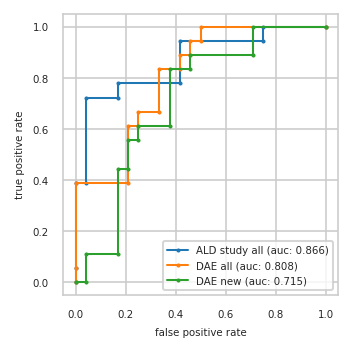

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.389   0.042 0.111
3          0.042 0.389   0.208 0.389   0.167 0.111
4          0.042 0.722   0.208 0.611   0.167 0.444
5          0.167 0.722   0.250 0.611   0.208 0.444
6          0.167 0.778   0.250 0.667   0.208 0.556
7          0.417 0.778   0.333 0.667   0.250 0.556
8          0.417 0.944   0.333 0.833   0.250 0.611
9          0.750 0.944   0.417 0.833   0.375 0.611
10         0.750 1.000   0.417 0.889   0.375 0.833
11         1.000 1.000   0.458 0.889   0.458 0.833
12           NaN   NaN   0.458 0.944   0.458 0.889
13           NaN   NaN   0.500 0.944   0.708 0.889
14           NaN   NaN   0.500 1.000   0.708 1.000
15           NaN   NaN   1.000 1.000   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,Q92542;Q92542-2,A0A087WXB8;Q9Y274
2,Q99969,O95450;O95450-2,P51688
3,P61981,P61981,J3KSJ8;Q9UD71;Q9UD71-2
4,P04075,Q9Y2T3;Q9Y2T3-3,P31321
5,P14174,C9JIZ6;P07602;P07602-2;P07602-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P00338;P00338-3,Q14894,P10644;P10644-2
7,P05160,P63104,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
8,C9JF17;P05090,P04075,P51674;P51674-2;P51674-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


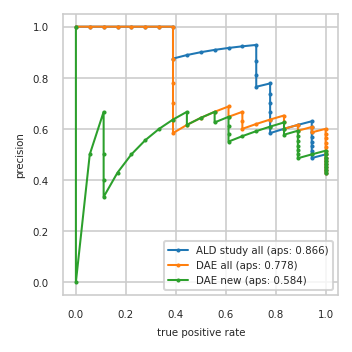

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.593 0.889     0.593 0.889
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.600 0.833     0.600 0.833     0.600 0.833
18         0.583 0.778     0.625 0.833     0.625 0.833
19         0.609 0.778     0.652 0.833     0.609 0.778
20         0.636 0.778     0.636 0.778     0.591 0.722
21         0.667 0.778     0.619 0.722     0.571 0.667
22         0.700 0.778     0.600 0.667     0.550 0.611
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.778 0.778     0.667 0.667     0.611 0.611
25         0.765 0.722     0.647 0.611     0.647 0.611
26         0.812 0.722     0.688 0.611     0.625 0.556
27         0.867 0.722     0.667 0.556     0.667 0.556
28         0.929 0.722     0.643 0.500     0.643 0.500
29         0.923 0.667     0.615 0.444     0.615 0.444
30         0.917 0.611     0.583 0.389     0.667 0.444
31         0.909 0.556     0.636 0.389     0.636 0.389
32         0.900 0.500     0.700 0.389     0.600 0.333
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.333 0.111
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


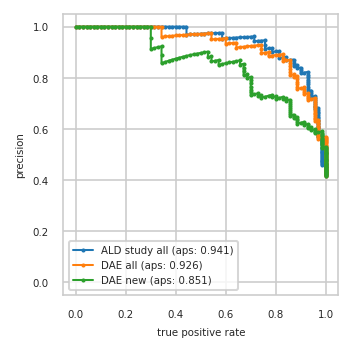

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


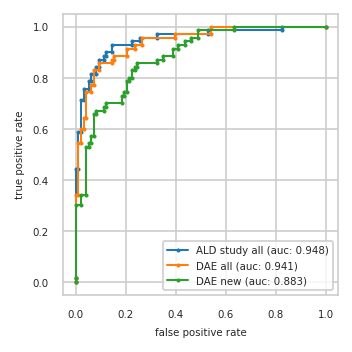

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}